## XGBoost modifications
 - V2 : Use class weight

>- import packages

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import KFold, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib 
from pathlib import Path

from sklearn.utils.class_weight import compute_class_weight


>- Define function & modify

In [3]:
# Define functions to calculate NDVI and NDWI
def calculate_ndvi(nir, red):
    return (nir - red) / (nir + red + 1e-10)

def calculate_ndwi(nir, swir):
    return (nir - swir) / (nir + swir + 1e-10)

'''
    Enhanced Feature Engineering:
        -  Current features (mean NDVI/NDWI) might be insufficient. Add:

'''
def extract_features(image_path):
    with rasterio.open(image_path) as src:
        bands = src.read()
        nir, red, swir = bands[3], bands[2], bands[4]
        
        # Existing features
        ndvi = calculate_ndvi(nir, red)
        ndwi = calculate_ndwi(nir, swir)
        
        # New features
        return [
            np.mean(ndvi), np.std(ndvi),  # Add standard deviation
            np.mean(ndwi), np.std(ndwi),
            np.percentile(nir, 75),  # Texture features
            np.mean(swir > np.quantile(swir, 0.75))  # Threshold features
        ]


def calculate_class_weights(y):
    """Calculate class weights for imbalanced datasets"""
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    return {i: w for i, w in enumerate(weights)}

>- load dataset

In [4]:
# Load dataset efficiently
train_dataset_path = Path('../../../data/model/Patches/Train/')
test_dataset_path = Path('../../../data/model/Patches/Test/')
growth_stages = ["germination", "tillering", "grand_growth", "ripening"]
X, X_test, y, y_test = [], [], [], []

for idx, stage in enumerate(growth_stages):
    stage_path = train_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X.append(extract_features(img_path))
        y.append(idx)

X = np.array(X)
y = np.array(y)

for idx, stage in enumerate(growth_stages):
    stage_path = test_dataset_path / stage
    for img_file in os.listdir(stage_path):
        img_path = stage_path / img_file
        X_test.append(extract_features(img_path))
        y_test.append(idx)

X_test = np.array(X_test)
y_test = np.array(y_test)

>- setup model

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:43:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
[0]	validation_0-mlogloss:1.22218	validation_1-mlogloss:1.22483
[1]	validation_0-mlogloss:1.08435	validation_1-mlogloss:1.08881
[2]	validation_0-mlogloss:0.96962	validation_1-mlogloss:0.97608
[3]	validation_0-mlogloss:0.87563	validation_1-mlogloss:0.88385
[4]	validation_0-mlogloss:0.79071	validation_1-mlogloss:0.80031
[5]	validation_0-mlogloss:0.71917	validation_1-mlogloss:0.72970
[6]	validation_0-mlogloss:0.65807	validation_1-mlogloss:0.66976
[7]	validation_0-mlogloss:0.60106	validation_1-mlogloss:0.61377
[8]	validation_0-mlogloss:0.55823	validation_1-mlogloss:0.57181
[9]	validation_0-mlogloss:0.51513	validation_1-mlogloss:0.52942
[10]	validation_0-mlogloss:0.47789	validation_1-mlogloss:0.49285
[11]	validation_0-mlogloss:0.44345	validation_1-mlogloss:0.45918
[12]	validation_0-mlogloss:0.41049	validation_1-mlogloss:0.42743
[13]	validation_0-mlogloss:0.38211	validation

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\xgboost\core.py:158: UserWarning: [19:43:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-mlogloss:0.27830	validation_1-mlogloss:0.29913
[19]	validation_0-mlogloss:0.26268	validation_1-mlogloss:0.28411
[20]	validation_0-mlogloss:0.24793	validation_1-mlogloss:0.26969
[21]	validation_0-mlogloss:0.23639	validation_1-mlogloss:0.25836
[22]	validation_0-mlogloss:0.22408	validation_1-mlogloss:0.24668
[23]	validation_0-mlogloss:0.21492	validation_1-mlogloss:0.23779
[24]	validation_0-mlogloss:0.20508	validation_1-mlogloss:0.22875
[25]	validation_0-mlogloss:0.19559	validation_1-mlogloss:0.21986
[26]	validation_0-mlogloss:0.18809	validation_1-mlogloss:0.21284
[27]	validation_0-mlogloss:0.18052	validation_1-mlogloss:0.20543
[28]	validation_0-mlogloss:0.17354	validation_1-mlogloss:0.19894
[29]	validation_0-mlogloss:0.16758	validation_1-mlogloss:0.19305
[30]	validation_0-mlogloss:0.16233	validation_1-mlogloss:0.18811
[31]	validation_0-mlogloss:0.15722	validation_1-mlogloss:0.18331
[32]	validation_0-mlogloss:0.15211	validation_1-mlogloss:0.17841
[33]	validation_0-mloglos

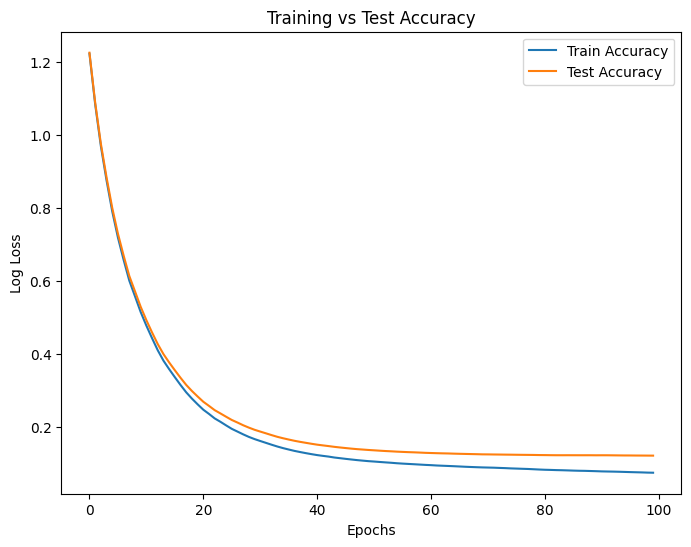

In [6]:
# Define parameter grid for XGBoost
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Initialize XGBoost and GridSearchCV
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False, 
    eval_metric='mlogloss',
    scale_pos_weight=calculate_class_weights(y), 
    random_state=42
    )

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, n_jobs=-1, verbose=2, return_train_score=True)

# Train model with cross-validation
grid_search.fit(X, y)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Train the model on the entire training dataset
history = best_model.fit(X, y, eval_set=[(X, y), (X_test, y_test)], verbose=True)

# Plot training and test accuracy
eval_results = best_model.evals_result()
train_accuracy = eval_results['validation_0']['mlogloss']
test_accuracy = eval_results['validation_1']['mlogloss']

plt.figure(figsize=(8, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.savefig(Path("../../../IMG/NEW/XGB_V4_accuracy_plot.png"))
plt.show()

>- evaluate model

Test Accuracy: 0.9455128205128205
Test Precision: 0.9462354756445437
Test Recall: 0.9455128205128205
Test F1 Score: 0.9458461273732695
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2071
           1       0.78      0.81      0.79       499
           2       1.00      0.99      1.00       984
           3       0.99      0.99      0.99       502

    accuracy                           0.95      4056
   macro avg       0.93      0.93      0.93      4056
weighted avg       0.95      0.95      0.95      4056

Saved model to: ..\..\..\models\Map\xgb_model_v4.joblib
Best Cross-Validation Accuracy: 95.17%


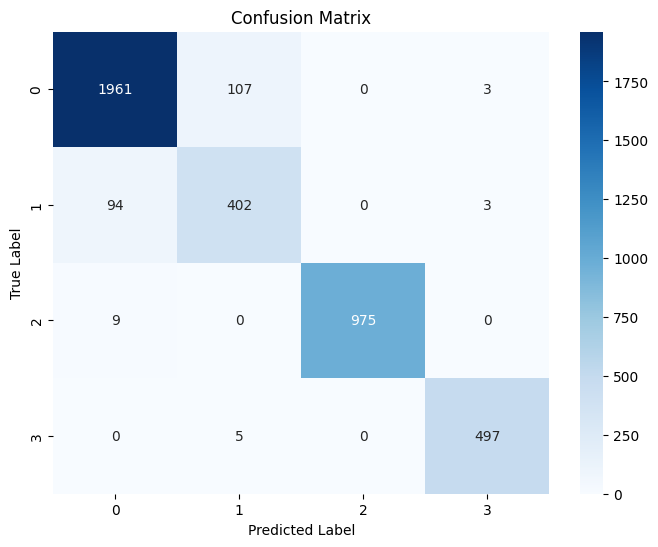

In [8]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# Calculate additional metrics
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
confusion = confusion_matrix(y_test, y_test_pred)

# Log confusion matrix as an image
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(Path("../../../IMG/NEW/XGB_V4_confusion_matrix.png")) # Save confusion matrix

# Print results
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Classification Report:\n{test_report}")

# Save the best model to disk
xgb_model_v4 = Path("../../../models/Map/xgb_model_v4.joblib")
joblib.dump(best_model, xgb_model_v4)
print(f"Saved model to: {xgb_model_v4}")

# Evaluate using cross-validation accuracy
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

>- predict

In [9]:
# Load the best model
model = joblib.load(Path("../../../models/Map/xgb_model_v4.joblib"))

def predict_growth_stage(image_path, model):
    features = extract_features(image_path)
    predicted_label = model.predict([features])[0]
    return growth_stages[predicted_label]

new_image = Path('../../../data/model/Test/grand_growth/grand_growth_118FPLAN_76.tif')
predicted_stage = predict_growth_stage(new_image, model)
print(f"Predicted Growth Stage: {predicted_stage}")
print()

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Predicted Growth Stage: grand_growth

